# Coursework 1
**Replace CID in the file name with your CID**

# Outline


- [Task 1](#task-1): Linear regression and feature selection <a name="index-task-1"></a>
  - [(1.1)](#task-11) <a name="index-task-11"></a>
  - [(1.2)](#task-12) <a name="index-task-12"></a>
  - [(1.3)](#task-13) <a name="index-task-13"></a>
  - [(1.4)](#task-14) <a name="index-task-14"></a>
- [Task 2](#task-2): Non-linear regression with Kernel Ridge Regression <a name="index-task-2"></a>
  - [(2.1)](#task-21) <a name="index-task-21"></a>
  - [(2.2)](#task-22)  <a name="index-task-22"></a>
- [Task 3](#task-3): Classification with the Multi-Layer Perceptron <a name="index-task-3"></a>
  - [(3.1)](#task-31) <a name="index-task-31"></a>
  - [(3.2)](#task-32)  <a name="index-task-32"></a>

In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

rng = np.random.default_rng(108)

### Data Preprocessing

In [61]:
train_data = pd.read_csv("data/asteroid_observations_train.csv")
test_data = pd.read_csv("data/asteroid_observations_test.csv")
train_data.head()

,Absolute magnitude,Albedo,Number of observations,Observation arc length,Orbital eccentricity,Orbital inclination,Orbital period,Asteroid diameter,Asteroid class
0,18.1,0.041,15,2.0,0.201590,11.975800,3.912298,1.573,MBA
1,12.5,0.139,349,7208.0,0.032746,8.793883,11.942668,12.355,TJN
2,14.1,0.062,705,25309.0,0.179314,27.433960,5.749452,8.862,OMB
3,16.9,0.097,91,3805.0,0.066114,13.813845,4.592982,2.139,MBA
4,11.5,0.062,1300,9606.0,0.008824,5.595907,12.006096,30.763,TJN


In [62]:
# This function is taken from Week 4 tutorial
def standardise(X, X_train_=None):
    """
    Standardise features.

    Parameters:
        X (np.array): Feature matrix.
        X_train_ (np.array): An optional feature matrix to compute the statistics
            from before applying it to X. If None, just use X to compute the statistics.

    Returns:
        X_std (np.array): Standardised feature matrix
    """
    if X_train_ is None:
        X_train_ = X

    mu = np.mean(X_train_, axis=0, keepdims=True)
    sigma = np.std(X_train_, axis=0, keepdims=True)
    X_std = (X - mu) / sigma

    return X_std

def add_int(X):
    # Add a column of ones to a matrix X
    N = X.shape[0]
    X_aug = np.hstack([np.ones((N,1)), X])  
    return X_aug

In [63]:
train_arr = train_data.to_numpy()
test_arr = test_data.to_numpy()

X_train = train_arr[:, :-2].astype(float)
y_train_diam = train_arr[:, -2].astype(float)
y_train_class = train_arr[:, -1].astype(str)
X_test = test_arr[:, :-2]
y_test_diam = test_arr[:, -2].astype(float)
y_test_class = test_arr[:, -1].astype(str)


In [64]:

X_train_std = standardise(X_train)
X_test_std = standardise(X_test, X_train)



---



<a name="task-1"></a>

# Task 1: Linear regression and feature selection [(index)](#index-task-1)

<a name="task-11"></a>

## (1.1) [(index)](#index-task-11)

In [ ]:
N, p = X_train_std.shape
X_aug = add_int(X_train_std) # augmented training inputs of size N x (p+1)
beta_aug = np.zeros((p+1, 1)) # new beta vector of size (p+1) x 1

In [7]:
# These functions are taken from Week1 Tutorial

def max_lik_estimate(X, y):

    # X: N x p matrix of training inputs
    # y: N x 1 vector of training targets/observations
    # returns: maximum likelihood parameters (p x 1)

    # check X and y have the same length
    assert X.shape[0] == y.shape[0], "Input X and y have different lengths."

    N, p = X.shape
    beta_ml = np.linalg.inv(X.T @ X) @ X.T @ y
    return beta_ml

def max_lik_estimate_aug(X_aug, y):

    beta_aug_ml = np.linalg.inv(X_aug.T @ X_aug) @ X_aug.T @ y

    return beta_aug_ml

# huber loss
def huber(beta, c = 1e-4):
    return np.where(np.abs(beta) < c, (beta**2)/2.,c * (np.abs(beta) - c/2))

# gradient of huber loss
def grad_huber(beta, c = 1e-4):
    g = np.empty_like(beta)
    return  np.where(np.abs(beta) < c, beta, c * np.sign(beta))



Here one replaces $||\boldsymbol{g}||_1$ with the Huber Loss $\sum_{i=1}^p L_c(g_i)$, where $L_c(g_i)$ is defined as:

$L_c (g_i) =
\begin{cases}
 \frac{1}{2}{g^2_i}                   & \text{for } |g_i| \le c, \\
 c (|g_i| - \frac{1}{2}c), & \text{otherwise,}
\end{cases}
$

for $i=1,\ldots,p$.

The $c$ parameter in Huber determines the range around zero with $L_2$-like behaviour to ensure smoothness and, hence, better convergence.

The piecewise smooth function $L_c (g_i)$ has the gradient:

$\frac{dL_c (g_i)}{dg_i} =
  \begin{cases}
 g_i                   & \text{for } |g_i| \le c, \\
 c\, \text{sign}(g_i) , & \text{otherwise,}
\end{cases}
$

for $i=1,\ldots,p$.

Now we can minimise the following relaxed function by gradient descent:

$$
\min_{g \in \mathbb{R}^p}
\frac{1}{N}
\sum_{i=1}^{N}
\left(
y^{(i)} - \sum_{j=1}^{p} x_{ij}\,\hat{\beta}_j^{LS}\, g_j
\right)^2
\quad
\text{subject to}
\quad
\sum_{j=1}^{p} |g_j| \le s
$$
 is equivalent to
$$
\min_{g \in \mathbb{R}^p}
\left\{
\frac{1}{2}
\sum_{i=1}^{N}
\left(
y_i - \sum_{j=1}^{p} x_{ij}\,\hat{\beta}_j^{LS}\, g_j
\right)^2
+
\lambda
\sum_{j=1}^{p} |g_j|
\right\}
$$


Which has the gradient:

\begin{align}
\nabla_{\boldsymbol{g}} L_{\text{Garrote-Huber}}
&= x^T \hat{\beta}^{LS}
+ \lambda \nabla_{\boldsymbol{g}} L_c(\boldsymbol{g})
\end{align}




In [ ]:
def minimise_g(x, y, beta_ls_with_int, lam, n_iters=10**4, step_size=1e-7, c_huber=1e-4):
    # x: size Nxp design matrix
    # y: size N vector of diameters
    # beta_ls_wtih_int: size p+1 vector of Least Squares estimators with the intercept beta0 term

    # Split beta into the intercept term and the rest (p terms)
    N = len(y)
    beta_ls = beta_ls_with_int[1::]
    beta0 = beta_ls_with_int[0]

    # Initialise g
    g = np.zeros(len(beta_ls)) + 1

    # Gradient descent to minimise g
    for i in range(n_iters):
        # Compute the gradient of Huber function
        grad_c = grad_huber(g, c=c_huber)


        # Compute the gradient of the regularised loss.
        grad =  beta_ls * (-2 * x.T @ (y - beta0 - x @ (beta_ls * g))) / N + lam * grad_c

        # Update beta
        g -= step_size * grad 

    return g * beta_ls

def fit_garrote(x, beta_g, beta_ls_with_int):
    beta0 = beta_ls_with_int[0]
    y = x @ beta_g + beta0
    return y


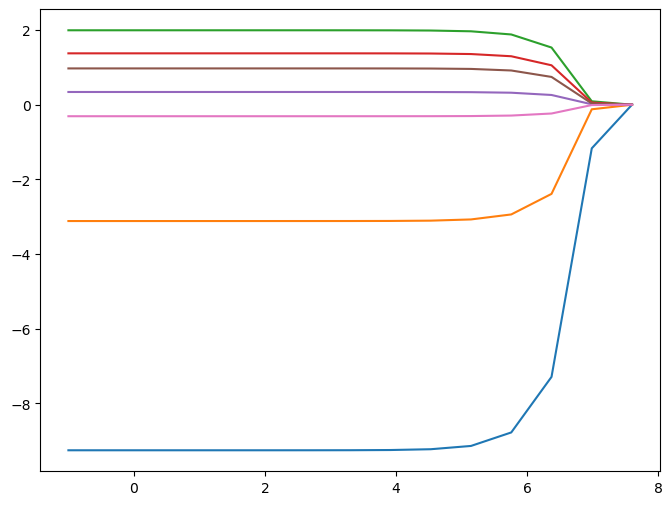

In [ ]:
lambdas = np.logspace(-1, 7.6, 15)
log_lambdas = np.log10(lambdas)

N, p = X_train_std.shape
X_aug = add_int(X_train_std) # augmented training inputs of size N x (p+1)
beta_ls_with_int = max_lik_estimate_aug(X_aug, y_train_diam)

beta_paths = []
for lam in lambdas:
    beta_g = minimise_g(X_train_std, y_train_diam, beta_ls_with_int, lam)
    beta_paths.append(beta_g)

beta_paths = np.array(beta_paths)

plt.figure(figsize=(8, 6))
plt.plot(log_lambdas, beta_paths)




<a name="task-12"></a>

## (1.2) [(index)](#index-task-12)

In [ ]:

def MSE_t(X_train, y_train, X_val, y_val, lam):

    # Predict fitted values y_hat
    X_aug = np.hstack([np.ones((len(y_train),1)), X_train]) # augmented training inputs of size N x (p+1)
    beta_ls_with_int = max_lik_estimate_aug(X_aug, y_train)
    beta_g = minimise_g(X_train, y_train, beta_ls_with_int, lam)
    y_hat = fit_garrote(X_val, beta_g, beta_ls_with_int)

    # Compute MSE
    MSE = np.mean((y_hat - y_val)**2)

    return MSE

def D(full_X, full_y, T, lam):

    #Split X and Y into T folds
    n = len(full_y)
    indices = np.arange(n)
    fold_indices = np.array_split(indices, T)
    MSEs = []

    for t in fold_indices:
        mask = np.zeros(len(full_y), dtype=bool)
        mask[t] = True
        X_train = full_X[~mask]
        X_val = full_X[mask]
        y_train = full_y[~mask]
        y_val = full_y[mask]
        MSEs.append(MSE_t(X_train, y_train, X_val, y_val, lam))
    D = np.mean(np.abs(np.diff(np.array(MSEs))))

    return D

319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
319
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
31
31
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
31
31
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
31
31
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
31
31
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
31
31
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
31
31
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
31
31
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
31
31
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
31
31
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
31
31
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
31
31
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
31
31
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
31
31
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
31
31
32
32
32
32
32
32
32
32
32
32
32
32
32
3

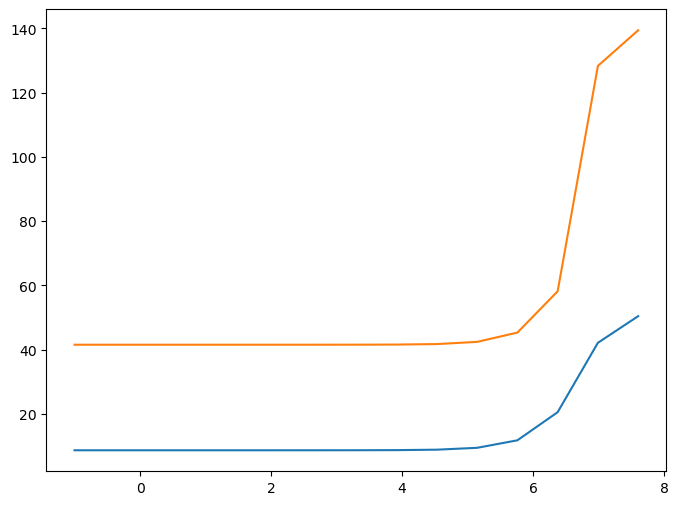

In [16]:
Ts = [2, 20]
Ds = []

for T in Ts:
    Ds.append([])
    for lam in lambdas:
        Ds[-1].append(D(X_train_std, y_train_diam, T, lam))

plt.figure(figsize=(8,6))
plt.plot(log_lambdas, Ds[0])
plt.plot(log_lambdas, Ds[1])

The graph suggests that as lambda becomes too high, D increases, hence the model becomes unstable. This makes sense, since for large values of lambda, the model prioritises shrinking the norm of the g vector, making hard, discontinuous feature-selection decisions, and those decisions can flip across folds, causing large jumps in validation MSE, thereby increasing D. The difference between T = 2 and T = 20 is that the result is stronger for T = 20, since successive training sets differ only slightly, so the D is even more sensitive to small perturbations in the data. For T = 2 training sets differ substantially between folds, so these local instabilities are partially masked, resulting in a weaker increase in D.

<a name="task-13"></a>

## (1.3) [(index)](#index-task-13)

### LASSO Regression

In [20]:
def minimize_ls_huber(X, y, lambd, n_iters = 10000, step_size=5e-5, c_huber=1e-4):
    """
    This function estimates the regression parameters with the relaxed version
    of LASSO regression using the gradient-descent algorithm to find the optimal
    solution.
    Args:
    X (np.array): The augmented data matrix with shape (N, p + 1).
    y (np.array): The response column with shape (N, 1).
    lambd (float): The multiplier of the relaxed L1 term.
    n_iters (int): Number of gradient descent iterations.
    step_size (float): The step size in the updating step.
    """

    # check X and y have the same length
    assert X.shape[0] == y.shape[0], "Input X and y have different lengths."

    N, p = X.shape
    # Precomputed products to avoid redundant computations.
    XX = X.T @ X
    Xy = X.T @ y
    # Initialize beta params with zeros
    beta = np.zeros(p)

    for i in range(n_iters):
        # Compute the gradient of the relaxed LASSO, Huber.
        grad_c = grad_huber(beta, c=c_huber)

        # Intercept term is not involved in the regularisation.
        grad_c[0] = 0 ## <-- EDIT THIS LINE

        # Compute the gradient of the regularised loss.
        grad =  2 * (XX @ beta - Xy) / N + lambd * grad_c ## <-- EDIT THIS LINE

        # Update beta
        beta -= step_size * grad ## <-- EDIT THIS LINE

    return beta

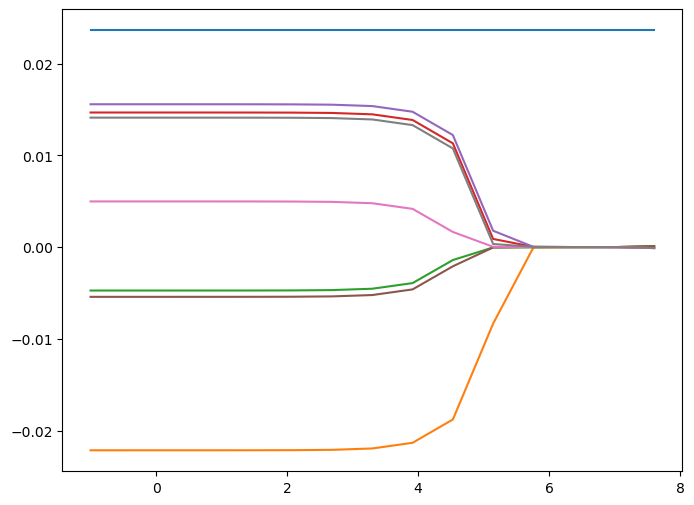

In [21]:
# Run LASSO regression for different lambdas

lasso_paths = []
for lam in lambdas:
    beta_lasso = minimize_ls_huber(X_aug, y_train_diam, lam, n_iters=10000,
                                step_size=1e-7,
                                c_huber=1e-4)
    lasso_paths.append(beta_lasso)

plt.figure(figsize=(8, 6))
plt.plot(log_lambdas, lasso_paths)


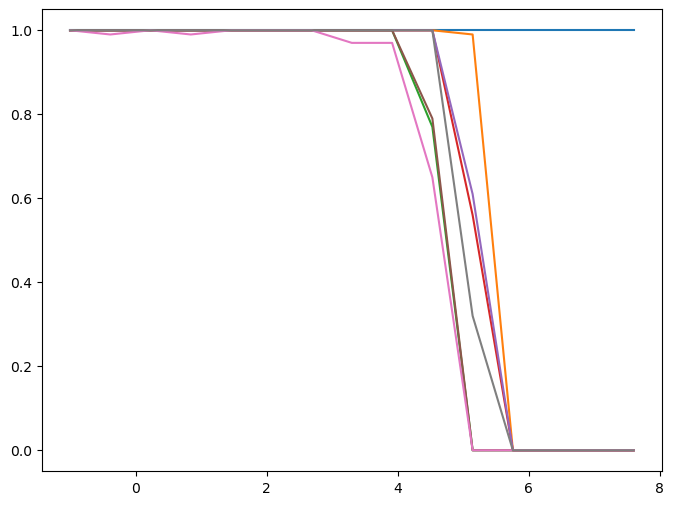

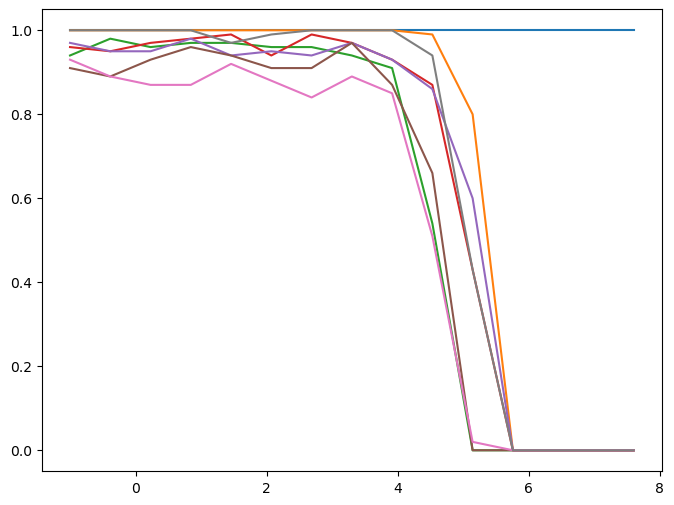

In [37]:
B = 100
N_dashes = [len(X_train_std) // 2, 50]
n = X_aug.shape[0]
prob_paths_Ns = []
for N_dash in N_dashes:
    prob_paths = []
    for lam in lambdas:

        features_bootstrap = []
        for i in range(B):
            idx = rng.choice(n, size=N_dash, replace=False)
            X_sample = X_aug[idx]
            y_sample = y_train_diam[idx]
            beta_lasso = minimize_ls_huber(X_sample, y_sample, lam, n_iters=10000,
                                        step_size=1e-7,
                                        c_huber=1e-4)
            feauters_selected = np.where(np.abs(beta_lasso) > 0.001, 1, 0)
            features_bootstrap.append(feauters_selected)
        feature_probabilities = np.array(features_bootstrap).mean(axis=0)
        prob_paths.append(feature_probabilities)
    prob_paths_Ns.append(prob_paths)

    plt.figure(figsize=(8, 6))
    plt.plot(log_lambdas, prob_paths)

(2, 15, 8)


<BarContainer object of 8 artists>

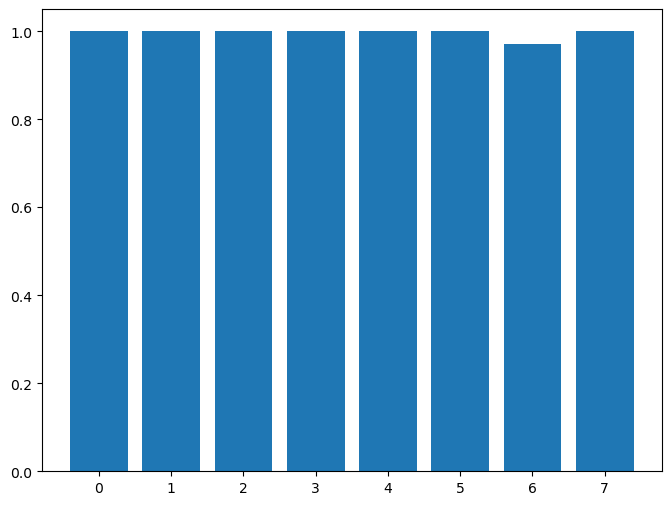

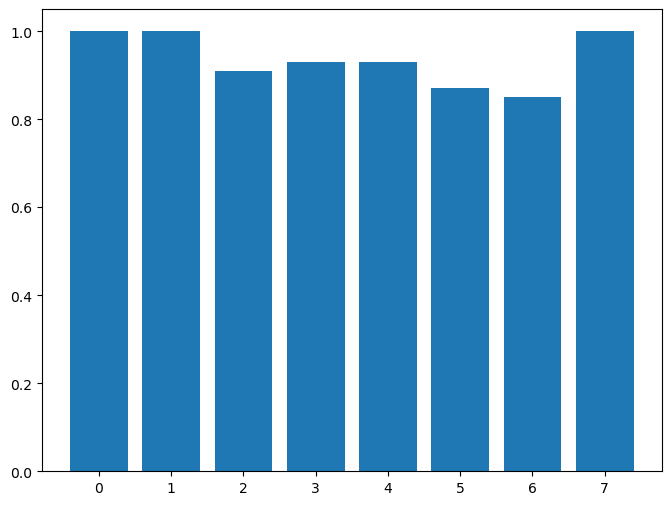

In [46]:
idx = 8
probs_arr = np.array(prob_paths_Ns)
print(probs_arr.shape)

probs_last_lambda = probs_arr[:, idx, :]

plt.figure(figsize=(8, 6))
plt.bar(np.arange(8), probs_last_lambda[0])
plt.figure(figsize=(8, 6))
plt.bar(np.arange(8), probs_last_lambda[1])

<a name="task-14"></a>

## (1.4) [(index)](#index-task-14)

<a name="task-2"></a>

# Task 2: Non-linear regression with Kernel Ridge Regression [(index)](#index-task-2)

In [ ]:
def r_squared(y_hat, y):
    return 1 - np.sum((y_hat - y)**2) / np.sum((y_hat - np.mean(y))**2)

def train_regression(X_train, y_train):
    X_train_aug = add_int(X_train)
    betas = max_lik_estimate(X_train_aug, y_train)
    return betas

def importance(X_test, y_test, feature, betas):
    y_hat_baseline = X_test @ betas
    r_squared_baseline = r_squared(y_hat_baseline, y_test)
    X_perm = X_test.copy()
    X_perm[:, feature] = rng.permutation(X_perm[:, feature])
    y_hat_perm = X_perm @ betas
    r_squared_perm = r_squared(y_hat_perm, y_test)

    return np.abs(r_squared_baseline - r_squared_perm)



In [ ]:
# From Week 2 notebook
def ridge_estimate(X, y, penalty):

    # X: N x p matrix of training inputs
    # y: N x 1 vector of training targets/observations
    # returns: maximum likelihood parameters ((p + 1) x 1)

    # check X and y have the same length
    assert X.shape[0] == y.shape[0], "Input X and y have different lengths."

    N, p = X.shape
    X_aug = add_int(X) # augmented training inputs of size N x (p + 1)
    N_aug, p_aug = X_aug.shape
    I = np.identity(p_aug)
    I[0] = 0.0 # penalty excludes the bias term.
    beta_ridge = np.linalg.inv(X_aug.T @ X_aug + penalty * np.eye(p_aug)) @ X_aug.T @ y ## <-- EDIT THIS LINE
    return beta_ridge

def fit_ridge(X_train, y_train, penalty, X_test):
    X_test_aug = add_int(X_test)
    betas = ridge_estimate(X_train, y_train, penalty)
    y_hat = X_test_aug @ betas
    return y_hat



y_fitted_train = fit_ridge(X_train_std, y_train_diam, 0.1, X_train_std)
y_fitted_test = fit_ridge(X_train_std, y_train_diam, 0.1, X_test_std)
print(r_squared(y_fitted_train, y_train_diam), r_squared(y_fitted_test, y_test_diam))

0.6776693245455665 0.6767505586491422


<a name="task-21"></a>

## (2.1) [(index)](#index-task-21)

<a name="task-22"></a>

## (2.2) [(index)](#index-task-22)

<a name="task-3"></a>

# Task 3: Classification with the Multi-Layer Perceptron [(index)](#index-task-3)

<a name="task-31"></a>

## (3.1) [(index)](#index-task-31)

<a name="task-32"></a>

## (3.2) [(index)](#index-task-32)